# 라이브러리

In [1]:
from numpy import loadtxt

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

from xgboost import XGBClassifier

# 학습하기

In [2]:
origin_df = pd.read_csv("../data/original_data.csv",index_col=['Date'],parse_dates=True)

n_list = [1,3,5,7,10,20,30,60,90]
for n in n_list:
    col_name = 'avg_price'+str(n)

    origin_df[col_name] = origin_df['Close'].rolling(window=n).mean()
    origin_df[col_name] = origin_df[col_name].shift(-n)
    # shift -n이면 해당일 제외 , shift -n-1이면 해당일 포함한 평균이다.
    diffs = origin_df[col_name]-origin_df['Close']
    label_name = 'label'+str(n)
    origin_df[label_name] = np.where(diffs>0,1,0)
    

df = origin_df['2011-01-01':'2020-12-31']
df.dropna(inplace=True)

<ipython-input-2-3369126531b1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [13]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4110 entries, 2005-01-04 to 2021-08-25
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4110 non-null   float64
 1   High          4110 non-null   float64
 2   Low           4110 non-null   float64
 3   Close         4110 non-null   float64
 4   Adj Close     4110 non-null   float64
 5   Volume        4110 non-null   int64  
 6   S&P500        3985 non-null   float64
 7   SOX           3984 non-null   float64
 8   VIX           3984 non-null   float64
 9   KOSPI         4089 non-null   float64
 10  log_return    4109 non-null   float64
 11  CCI           4097 non-null   float64
 12  MA5           4106 non-null   float64
 13  MA10          4101 non-null   float64
 14  MA20          4091 non-null   float64
 15  MA60          4051 non-null   float64
 16  MA20_ratio    4091 non-null   float64
 17  MA60_ratio    4051 non-null   float64
 18  MA20_volum

In [17]:
# 가격데이터
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return','Close']
# 기술지표 데이터
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10', 'MA20', 'MA60',
                 'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne',
                 'MTM1','MTM3','ROC','WPR','middle']
# 시장지표 데이터
feature3_list = ['S&P500', 'SOX', 'VIX','KOSPI']
# 라벨링에 사용할 데이터
feature4_list = ['next_price','next_rtn']
# 기술지표 중 가격 정보가 덜 드러나는 데이터 
feature5_list = ['CCI','ATR','MACD','MTM1','MTM3','ROC','WPR']
# 기술지표 중 가격 정보가 드러나는 데이터
feature6_list = ['RASD5','RASD10','MA5','MA10','ub','lb','middle', 'MA20', 'MA60',
                 'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne']
all_x_feature = feature1_list+feature2_list+feature3_list

In [115]:
if set(origin_df.columns[:31]) == set(all_x_feature):
    X = df[all_x_feature]


    # 설명성을 위해 Min Max Scaler를 사용하지 않음
    #scaler = MinMaxScaler()
    # scaler.fit(X)
    #X_scaled = scaler.transform(X)
    y = df['label30']

    X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=1234)

    # 학습 데이터로 모델을 학습시키기
    model = XGBClassifier(feature_names = X.columns.to_list())
    model.fit(X_train,y_train)

    # 예측하기
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # 평가하기
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy : %.2f%%' %(accuracy * 100.0))

[00:20:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:20:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 92.18%


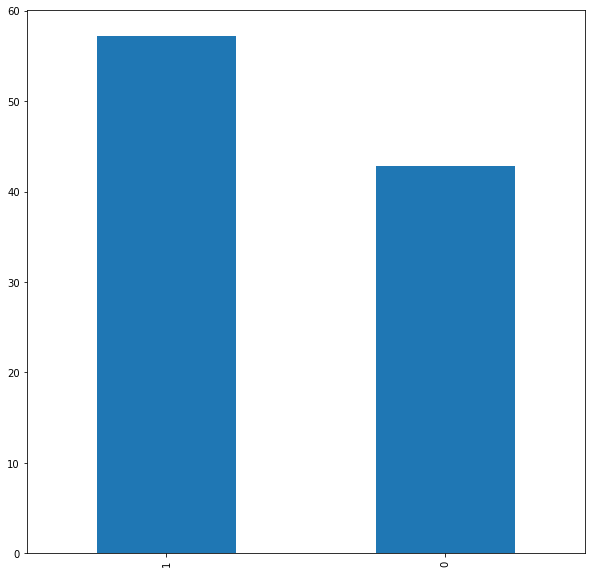

In [52]:
ratio = y.value_counts()/len(df) *100
ratio.plot.bar()

In [ ]:
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

fig, ax1 = plt.subplots(1,1,figsize = (12,6))

ax1.scatter(X['RM'], y, color='black', alpha=0.6)

ax1.set_title('Relation # of ')

# 설명 가능한 모델 결합하기

학습을 진행하면 정확도가 91.97%가 나온다. 파라미터 튜닝만으로는 위 모델이 어떤 원리로 주가가 상승할 것이라 예측하는지, 피처의 우선순위는 어떻게 구성되는지, 각 피처의 수치 변화에 따라 주가 상승 예측 가능성은 어떻게 변화하는지 등에 대한 질문에는 답할 수 없다. XAI 기법 없이는 파라미터의 복잡성이나 알고리즘 학습에 걸리는 시간 정도만 언급할 수 있을 뿐, 각 피처가 어떤 의미가 있거나 수치가 달라지는 상황에 대해서는 아무런 설명을 할 수 없다. 모델에 XAI를 결합하면 피처와 모델에 대한 해석이 가능해진다. 데이터 과학자는 머신러닝을 XAI모델에 응용함으로써 주가 전망에 대한 소견을 강화할 수 있고, 의사결정자들에게 예측 결과를 설명할 때 도움을 받을 수 있다. 또한, XAI는 튜닝을 하거나 새로운 피처를 고안할 때도 새로운 통찰을 준다.

* 기법1 : 의사 결정 트리 시각화
* 기법2 : 피처 중요도
* 기법3 : 부분 의존성 플롯

## 의사 결정 트리 시각화

의사 결정 트리는 부모 노드에서 내려갈수록 정보 이득량이 적어진다. 최상단 노드에서 코스피지수를 묻는다는 것은 해당 피처로 전망을 예측했을 때 정보 이득량이 가장 많다는 것을 간접적으로 시사한다. 이것을 시장이 좋은지 나쁜지에 따라 전망이 달라진다는 것으로 해석할 수 있다.본 주가 예측 모형은 코스피 지수를 1순위로 주가 전망을 예측한다.

In [24]:
%matplotlib inline
import os

from xgboost import plot_tree

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 100,300


참고로 종단 노드의 값은 로지스틱 함수 확률값으로 0은 중립, 음수는 하락, 양수는 상승으로 예측한다. 

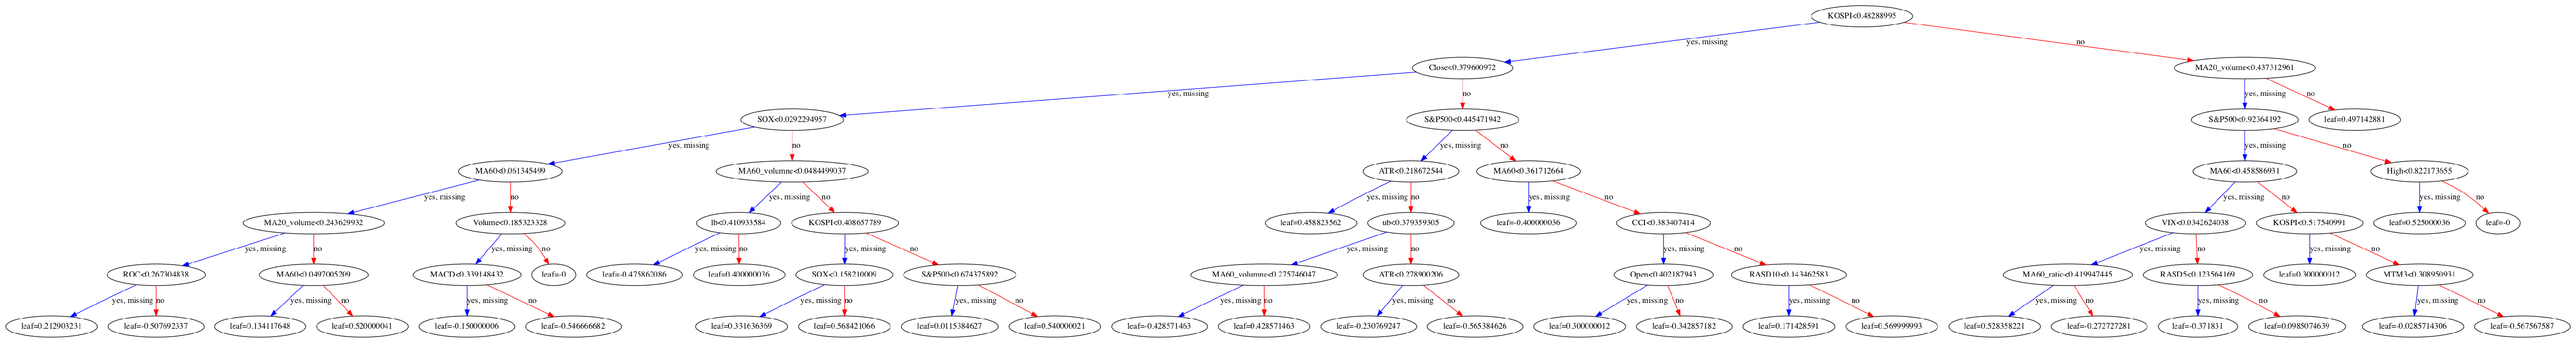

In [25]:
model.get_booster().feature_names = X.columns.tolist()
plot_tree(model)
plt.show()

### 가지치기 (프루닝)

모델이 너무 많은 의사 결정 가지를 그린다고 생각되면 XGBClassifier의 옵션을 변경해서 의사 결정 트리의 가지를 프루닝할 수 있다.

#### all features

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:04:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 85.62%


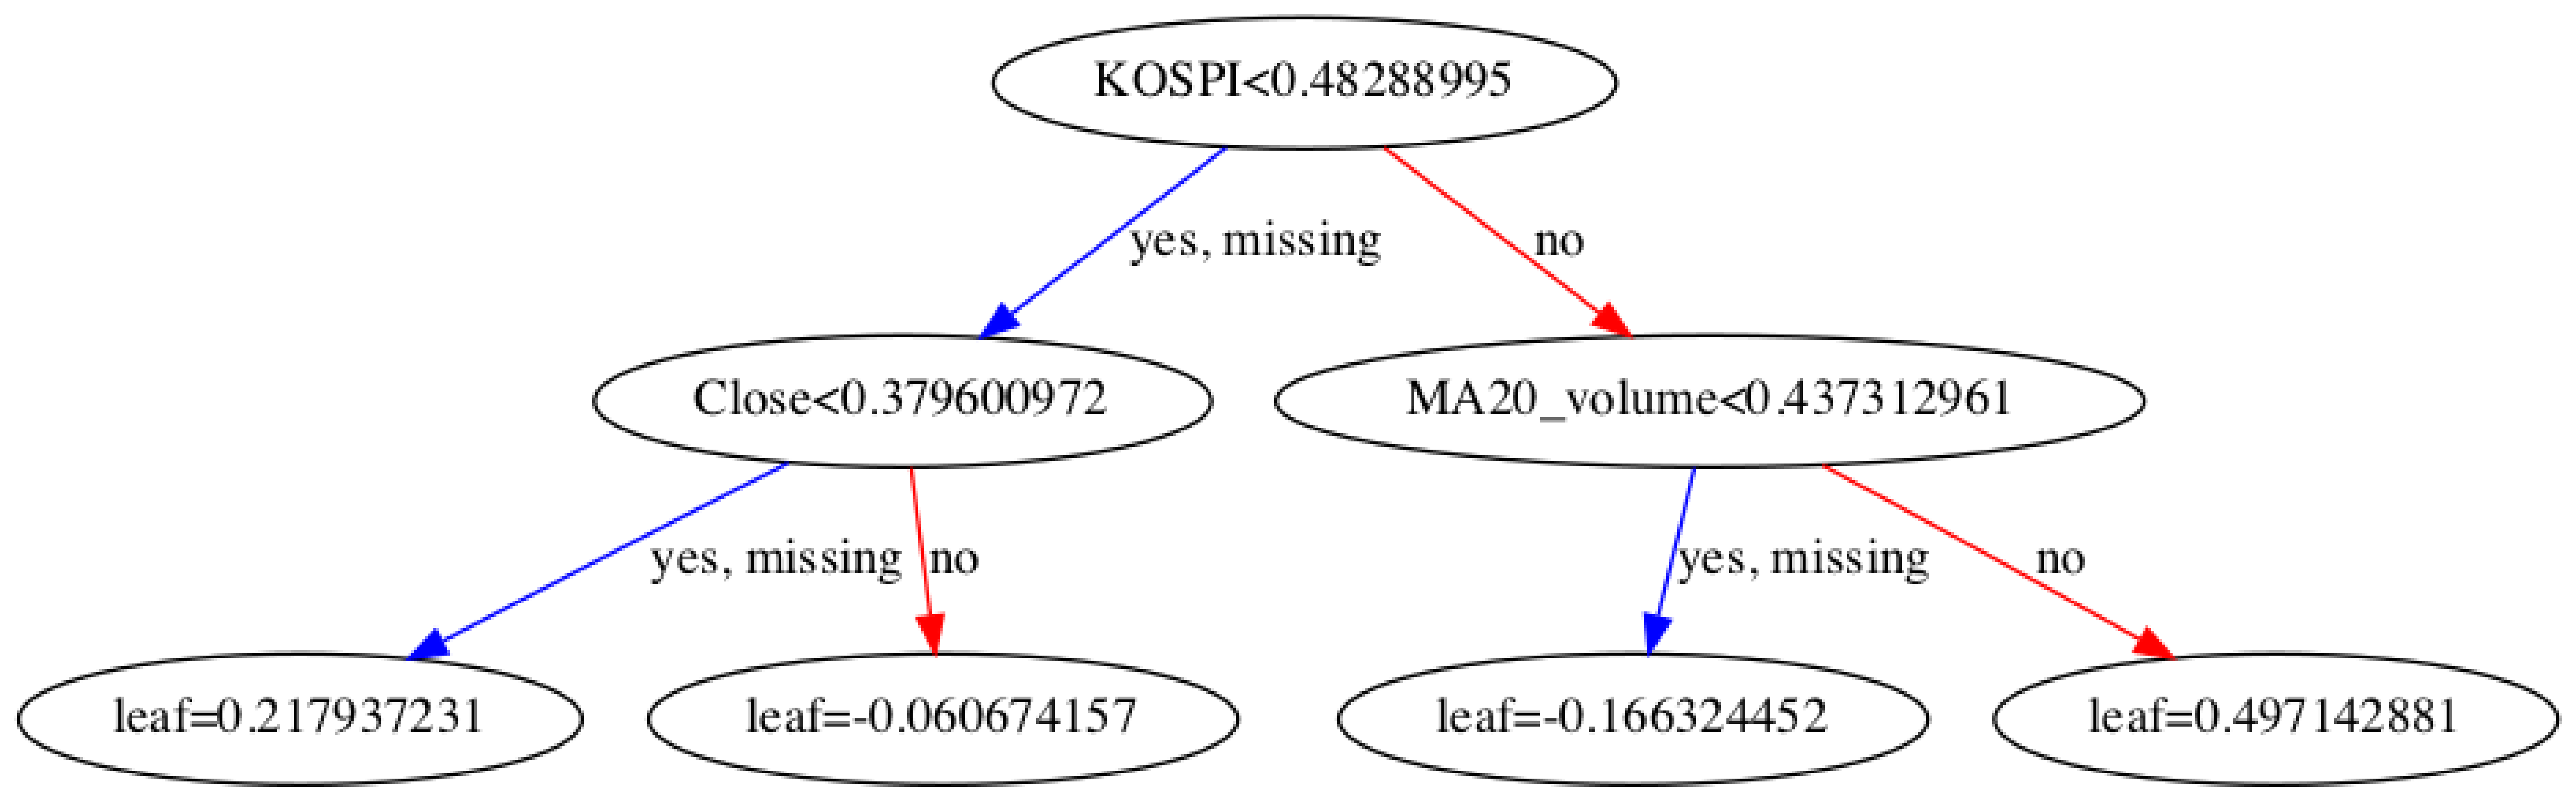

In [26]:
X = df[all_x_feature]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
y = df['label30']

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=1234)

simple_model = XGBClassifier(max_depth=2,
                            feature_names = X.columns.to_list())

simple_model.fit(X_train,y_train)

# 예측하기
y_pred = simple_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# 평가하기
accuracy = accuracy_score(y_test, predictions)
print('Accuracy : %.2f%%' %(accuracy * 100.0))


simple_model.get_booster().feature_names = X.columns.tolist()
plot_tree(simple_model)
plt.show()

#### 가격이 덜드라나는 기술지표 + 시장데이터

[00:19:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:19:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 79.92%


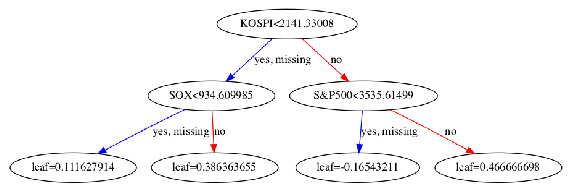

In [114]:
X = df[feature3_list+feature5_list]

# 설명성을 위해 Min Max Scaler를 사용하지 않음
#scaler = MinMaxScaler()
# scaler.fit(X)
#X_scaled = scaler.transform(X)
y = df['label30']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=1234)

simple_model = XGBClassifier(max_depth=2,
                            feature_names = X.columns.to_list())

simple_model.fit(X_train,y_train)

# 예측하기
y_pred = simple_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# 평가하기
accuracy = accuracy_score(y_test, predictions)
print('Accuracy : %.2f%%' %(accuracy * 100.0))


simple_model.get_booster().feature_names = X.columns.tolist()
plot_tree(simple_model)
plt.show()

## 피처 중요도 구분하기

피처 중요도는 특정 피처마다 한 번 씩 순회하면서 모델을 만들고 에러를 측정하며 피처중요도를 조정한다. 이때 중요한 점은 피처들 모두가 서로에게 상호의존성에 약해야 한다는 것이다. 예를들어 피처중요도에 BMI,키,몸무게가있다면 BMI는 키와 몸무게를 이용해 계산하므로 둘 중 하나를 임의의 값으로 변경하게되면 해당 피처를 임의의 값으로 변경한 모델 에러가 증가해 세 피처 모델에 대한 중요도가 다른 피처를 압도하게 된다. 따라서 피처중요도를 구할 때 피처 간 상호 의존성이 약해야하는 것이다.

## max_depth 가 6일 때

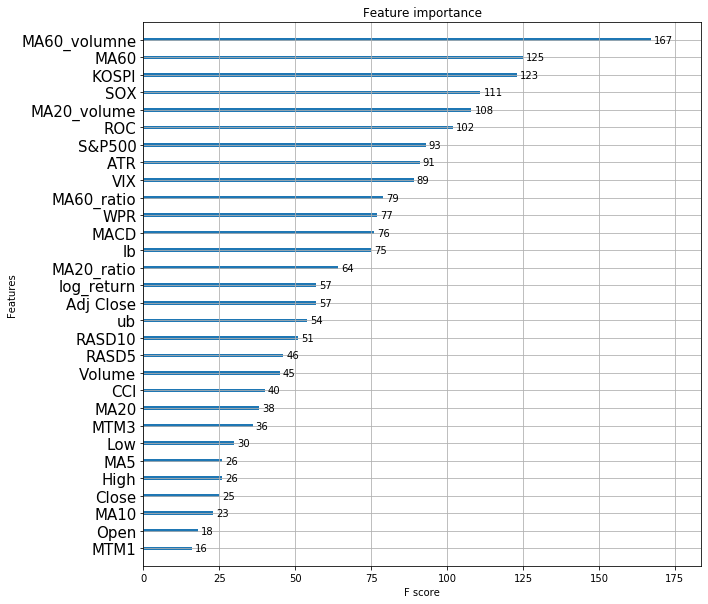

In [28]:
from xgboost import plot_importance


X = df[all_x_feature]

rcParams['figure.figsize'] = 10,10

model.get_booster().feature_names = list(X.columns)
plot_importance(model)

plt.yticks(fontsize = 15)
plt.show()

## max depth가 2일 때

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


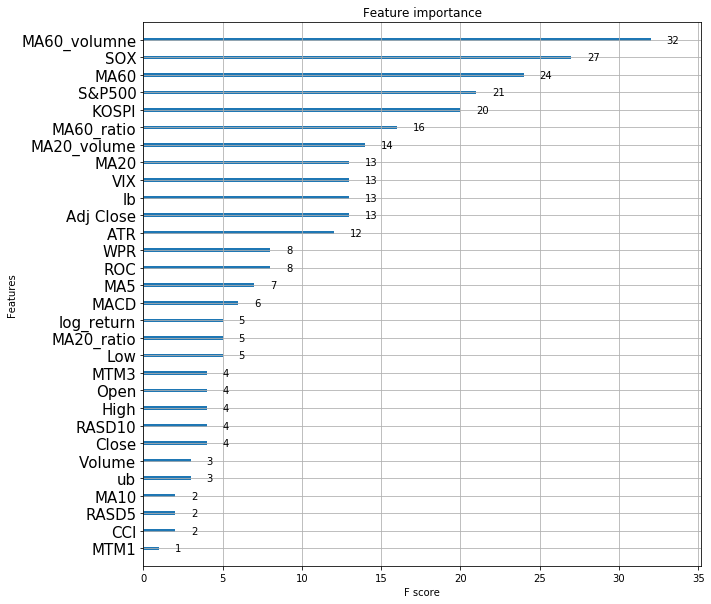

In [29]:
X = df[all_x_feature]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
y = df['label30']

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=1234)

simple_model = XGBClassifier(max_depth=2)

simple_model.fit(X_train,y_train)

X = df[all_x_feature]

rcParams['figure.figsize'] = 10,10

simple_model.get_booster().feature_names = X.columns.to_list()
plot_importance(simple_model)

plt.yticks(fontsize = 15)
plt.show()

## 부분 의존성 플롯 그리기

부분 의존성 플롯은 피처의 수치 변화에 따라 모델에 기여하는 정도가 어떻게 달라지는지 확인할 수 있는 XAI기법이다.
부분 의존성 플롯은 궁금한 피처가 모델에 긍정적/부정적 영향을 미치는지 파악하게 도울 뿐아니라, 특정 피처에 대해 여유분(buffer)을 함께 표시함으로써 피처 간 독립을 보장하지 못하는 환경에서 어느 정도 모델에 오차가 있을 수 있는지 확인하게 해준다. (현실세계에있는 피처들은 독립이 아닐 가능성이 많다.)

### 목표 플롯

목표플롯은 학습 데이터를 철저하게 분석해서 모델이 어떻게 학습할 것인지 예상하는 XAI기법이다. 즉, 모델을 파라미터로 이용하지 않고, 학습 데이터를 철저하게 분석할 수 있다면 모델을 예측할 수 있다는 것을 전제로 한다.

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


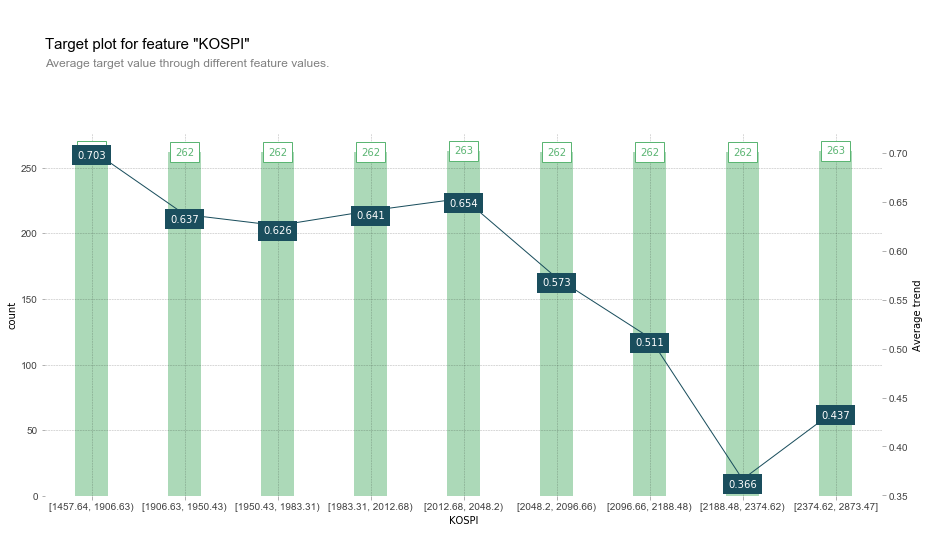

In [30]:
from pdpbox import info_plots
df1 = X.copy()
df1['trend'] = y

fig, axes, summary_df = info_plots.target_plot(
    df = df1,
    feature = 'KOSPI',
    feature_name = 'KOSPI',
    target = ['trend']
)

위 그림에서 X축은 KOSPI수치, 왼쪽 Y축은 각 수치 구간별 데이터 개수, 오른쪽 Y축은 주가 상승 가능 여부(>50%)다. 막대그래프는 왼쪽 Y축에 대응하고,
꺾은선 그래프는 오른쪽 Y축에 대응한다.

예를들어 코스피가 1950이라면 두 번째 막대그래프에 속하며, 데이터 수는 262개이다. 또한, 코스피가 1950인 날에 대해 수치만 관찰했을 때 주가 상승을 예측할
확률은 63.7%이다. 반대로 코스피가 2600인 날은 오른쪽 마지막 막대그래프에 속하며 이때 모델이 해당 일의 주가가 상승할 것이라 예측할 확률은 43.7%이다.
즉, 코스피지수가 너무 높으면 주가를 하락으로 예측하는 것이다.

## 과거의 코스피 가격을 보고 패턴을 읽은 것이어서...이게 정말 의미있는 모델인지 모르겠다...
가격정보가 들어가지 않은 데이터를 구성해서 예측해보는 것이 필요하지 않을까 생각됩니다.

summary_df는 위의 결과를 데이터프레임으로 저장한다.

In [32]:
summary_df

x      display_column  value_lower  value_upper  count     trend
0  0  [1457.64, 1906.63)  1457.640015  1906.633314    263  0.703422
1  1  [1906.63, 1950.43)  1906.633314  1950.427789    262  0.637405
2  2  [1950.43, 1983.31)  1950.427789  1983.306641    262  0.625954
3  3  [1983.31, 2012.68)  1983.306641  2012.675524    262  0.641221
4  4   [2012.68, 2048.2)  2012.675524  2048.195475    263  0.653992
5  5   [2048.2, 2096.66)  2048.195475  2096.656738    262  0.572519
6  6  [2096.66, 2188.48)  2096.656738  2188.479926    262  0.511450
7  7  [2188.48, 2374.62)  2188.479926  2374.615533    262  0.366412
8  8  [2374.62, 2873.47]  2374.615533  2873.469971    263  0.437262

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


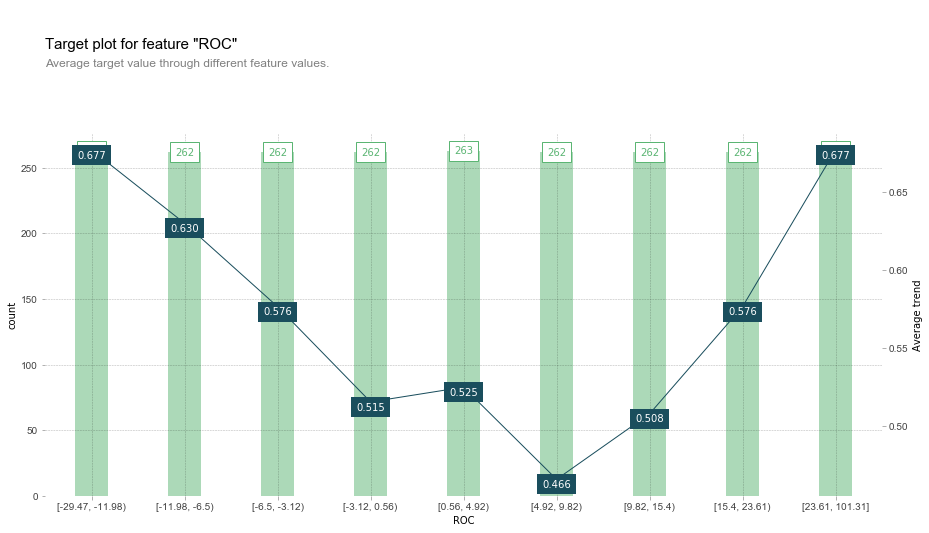

In [38]:
from pdpbox import info_plots
df1 = X.copy()
df1['trend'] = y

fig, axes, summary_df = info_plots.target_plot(
    df = df1,
    feature = 'ROC',
    feature_name = 'ROC',
    target = ['trend']
)

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


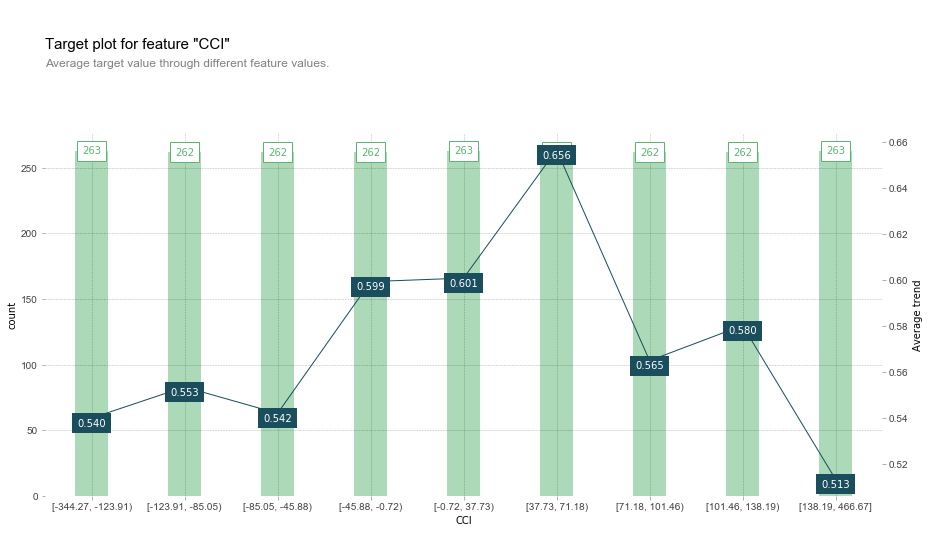

In [39]:
from pdpbox import info_plots
df1 = X.copy()
df1['trend'] = y

fig, axes, summary_df = info_plots.target_plot(
    df = df1,
    feature = 'CCI',
    feature_name = 'CCI',
    target = ['trend']
)

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


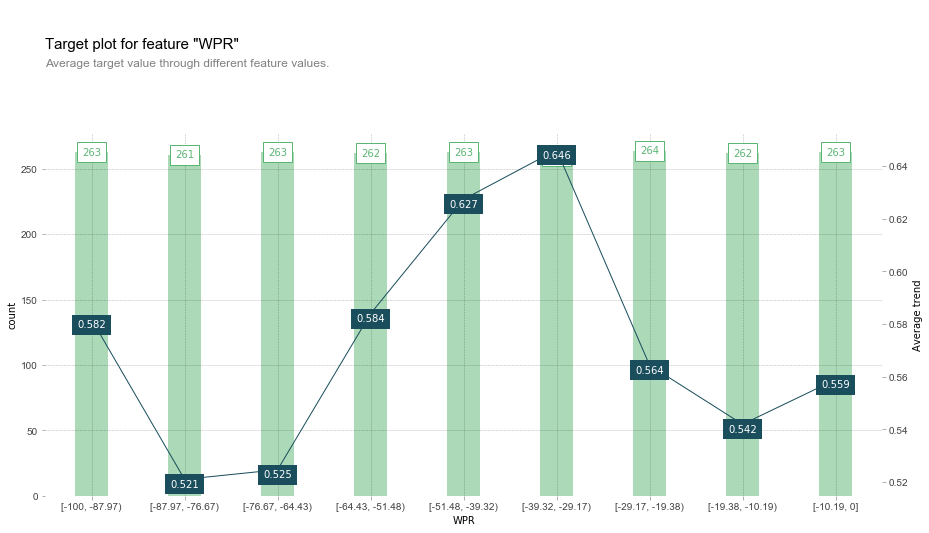

In [40]:
from pdpbox import info_plots
df1 = X.copy()
df1['trend'] = y

fig, axes, summary_df = info_plots.target_plot(
    df = df1,
    feature = 'WPR',
    feature_name = 'WPR',
    target = ['trend']
)

### 예측 분포 플롯 (prediction distribution plot)
데이터와 실제 모델을 결합해 두 결과가 일치하는지 확인해본다. 이 메서드는 모델이 학습 데이터의 빈도와 비슷한 추이로 당뇨병을 진단하는가를 예측한다.

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/pdpbox/info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

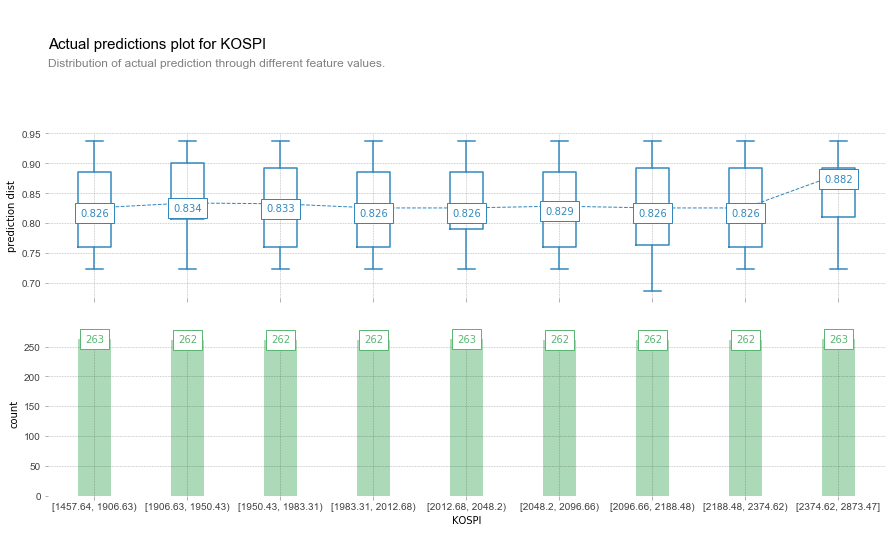

In [54]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model,
    X = df1[all_x_feature],
    feature = 'KOSPI',
    feature_name = 'KOSPI',
    predict_kwds={}
)

예측 분포는 모델이 특정 수치를 보이는 날짜에 주가가 상승될 것이라 추정하는 캔들 스틱 차트다.

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/pdpbox/info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

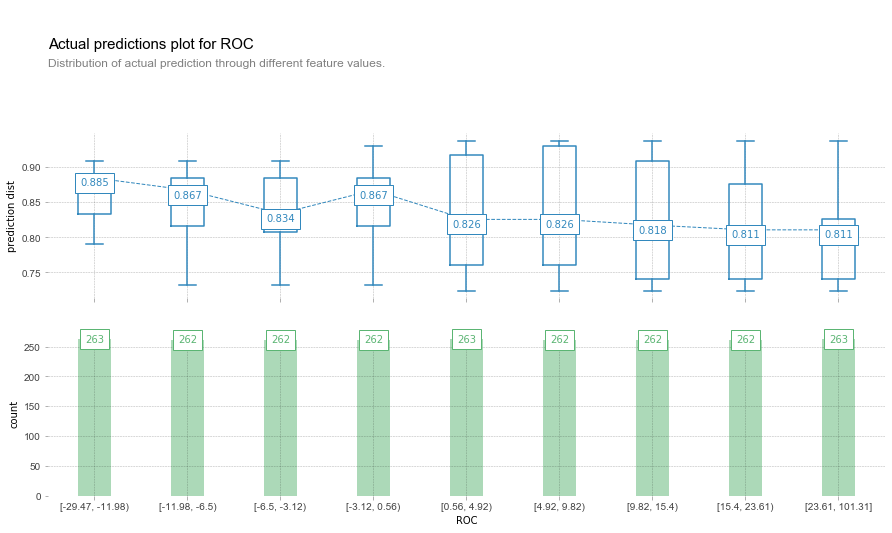

In [55]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model,
    X = df1[all_x_feature],
    feature = 'ROC',
    feature_name = 'ROC',
    predict_kwds={}
)

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/pdpbox/info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

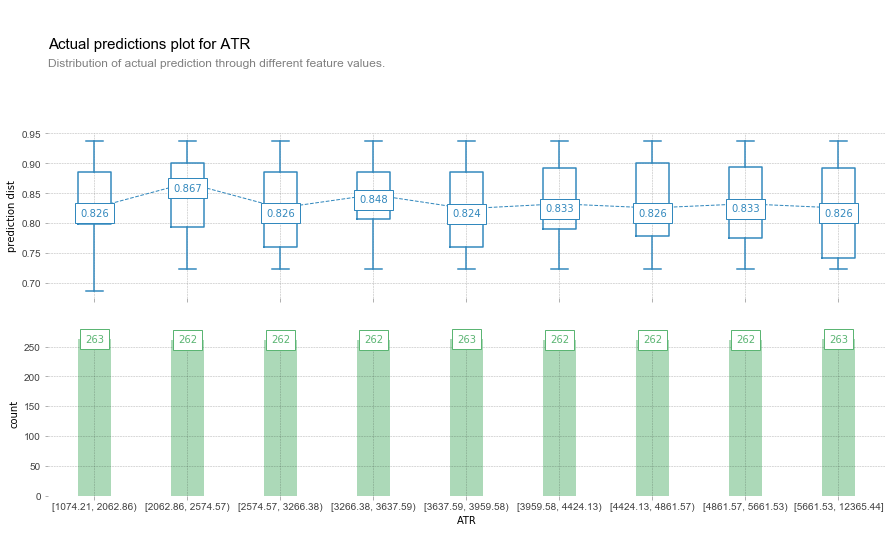

In [56]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model,
    X = df1[all_x_feature],
    feature = 'ATR',
    feature_name = 'ATR',
    predict_kwds={}
)

/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/pdpbox/info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/jihyun/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

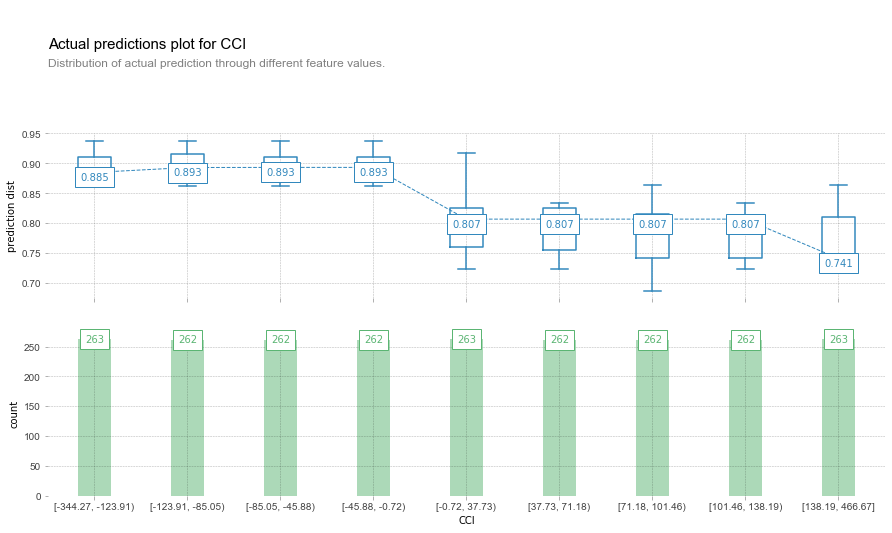

In [57]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model,
    X = df1[all_x_feature],
    feature = 'CCI',
    feature_name = 'CCI',
    predict_kwds={}
)

## 부분의존성 플롯

특정 피처에 대해 부분 의존성 플롯을 그린다.

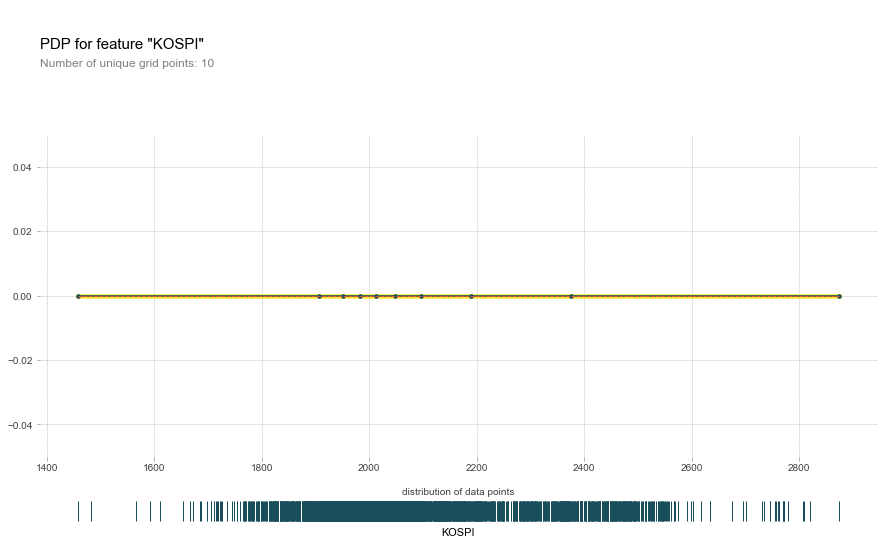

In [65]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'KOSPI'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'KOSPI',
        plot_lines = True,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

모든 구간에서 추세가 급격히 올라가는 부분을 발견할 수 없다. 특정 부분 의존성 계산 결과 모든 구간에 미치는 영향이 미미했기 때문이다. plot_pts_dist는 
특정 피처(X축)에 대해 데이터가 얼마나 분포했는지를 세로 막대로 표시한다. 이를 통해 부분 의존성 플롯 구간마다 얼마나 많은 데이터가 밀집돼 있는지 시각적으로
확인할 수 있다.

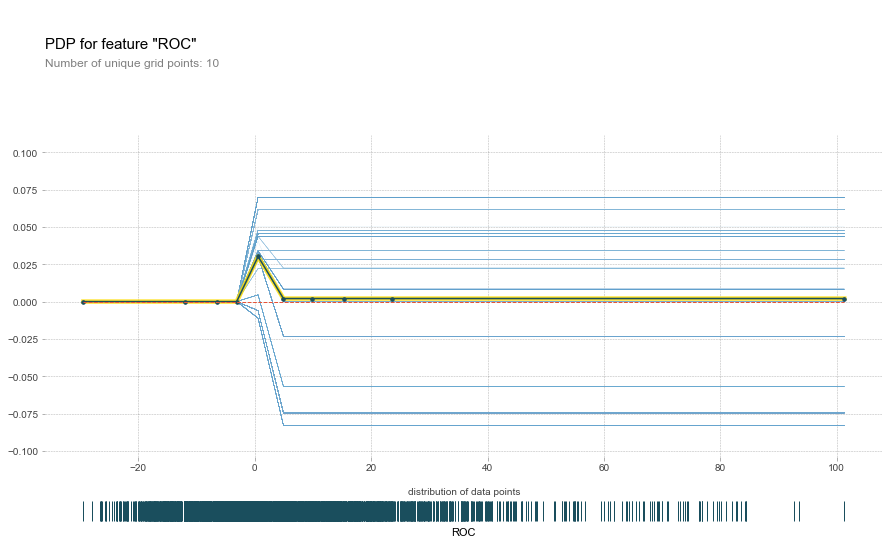

In [66]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'ROC'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'ROC',
        plot_lines = True,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

ROC가 0을 상향 돌파하면 매수를 하고,ROC가 0을 하향돌파하면 매도를 하는 전략이 어느정도 통할 수 있음을 위 그래프에서 확인할 수 있다.

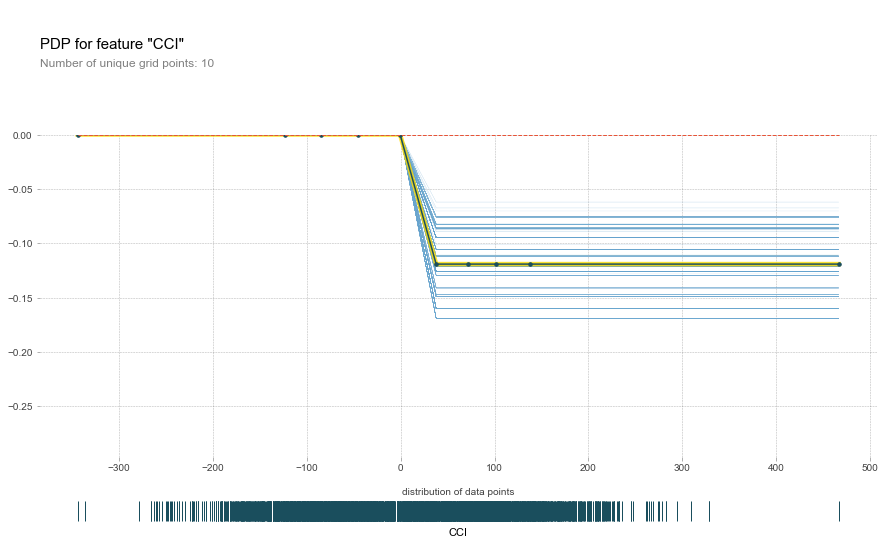

In [68]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'CCI'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'CCI',
        plot_lines = True,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

CCI가 +100 이상이면 과 매수 구간이므로 하락 전환이 예상된다는 것이 일반적인 내용인데 이를 위의 차트에서도 확인할 수 있다.

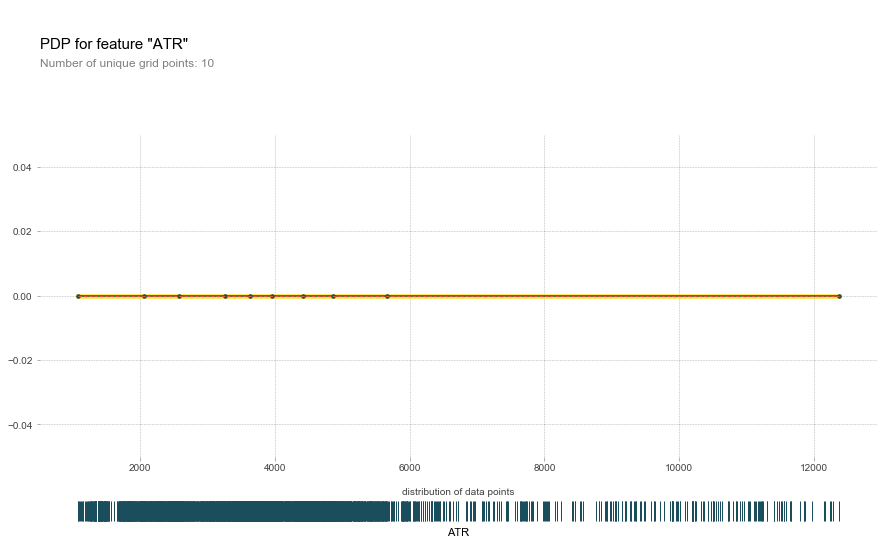

In [69]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'ATR'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'ATR',
        plot_lines = True,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

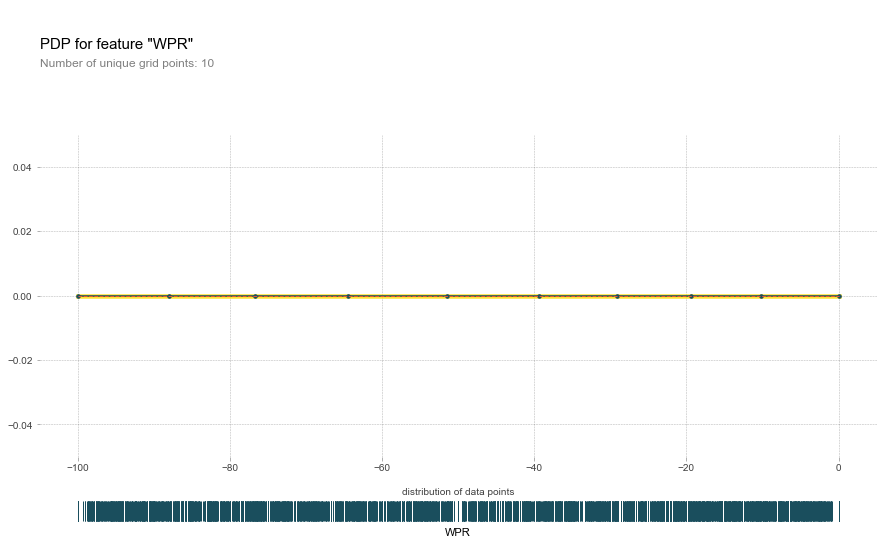

In [70]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'WPR'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'WPR',
        plot_lines = True,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

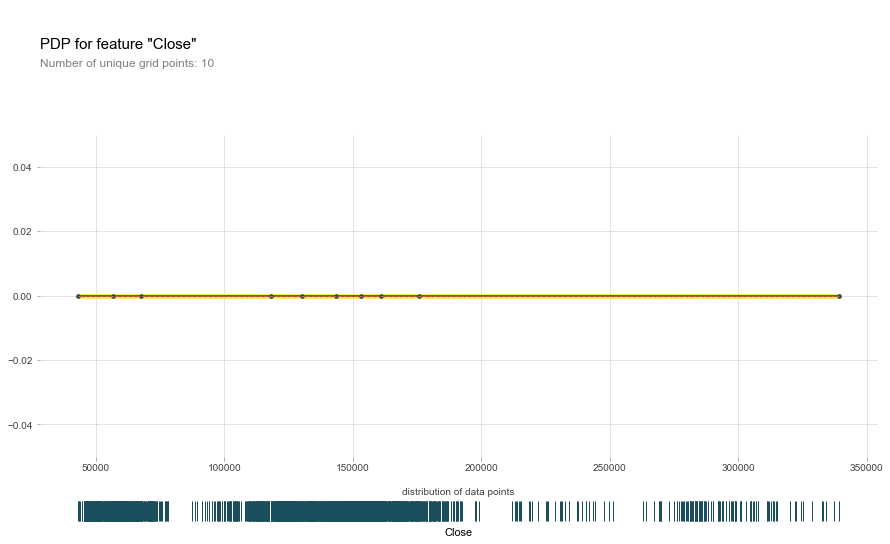

In [72]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'Close'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'Close',
        plot_lines = True,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

### 두 피처에 대한 목표 플롯
학습 데이터는 원의 크기로 표시된다. X,Y의 군집에 대해 원의 크기가 작을수록 사례가 적어지고, 원이 커질수록 사례가 많아진다. 주가 예측 진단은 원의 색으로 구분한다. 원 안의 색이 진할수록 주가 상승 가능성이 높아진다. 

In [77]:
def two_target_plots(df, feature_list, feature_names,target):
    fig, axes, summary_df = info_plots.target_plot_interact(
        df = df,
        features = feature_list,
        feature_names = feature_names,
        target = target)

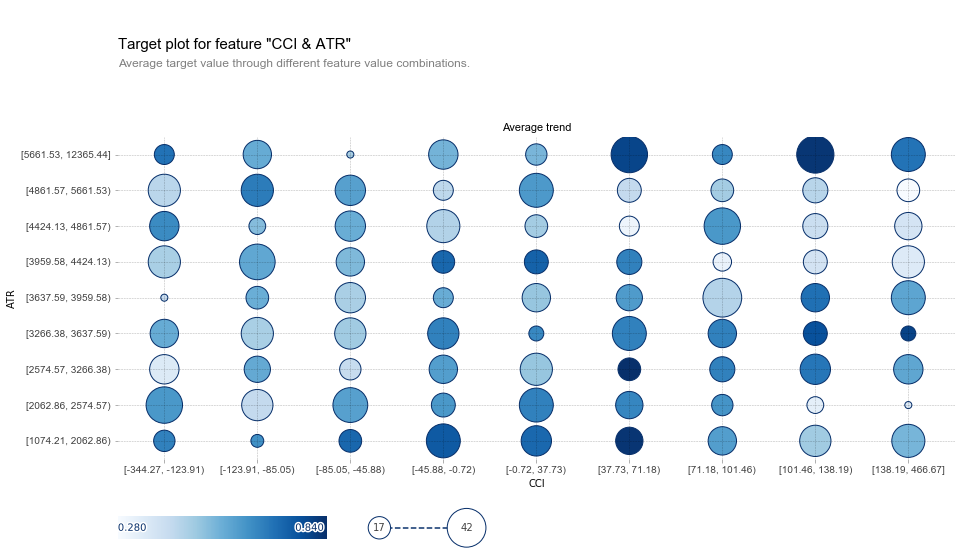

In [78]:
feature_list = ['CCI', 'ATR']
feature_names = ['CCI', 'ATR']
target = ['trend']
two_target_plots(df1, feature_list, feature_names, target)

### 두 피처에 대한 의존성 플롯

In [106]:
def two_plot_interaction(df,features,feature_list,plot_type):
    pdp_interaction = pdp.pdp_interact(
        model = model,
        dataset = df,
        model_features = features,
        features = feature_list
    )

    fig, axes = pdp.pdp_interact_plot(
        pdp_interact_out = pdp_interaction,
        feature_names = feature_list,
        plot_type = plot_type,
        x_quantile = True,
        plot_pdp = True
    )

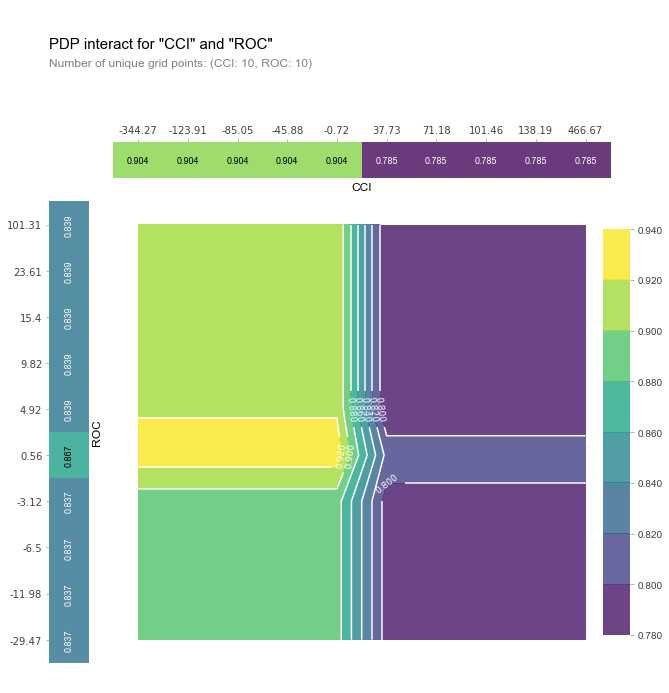

In [107]:
two_plot_interaction(df1,X.columns.tolist(),['CCI','ROC'],'contour')

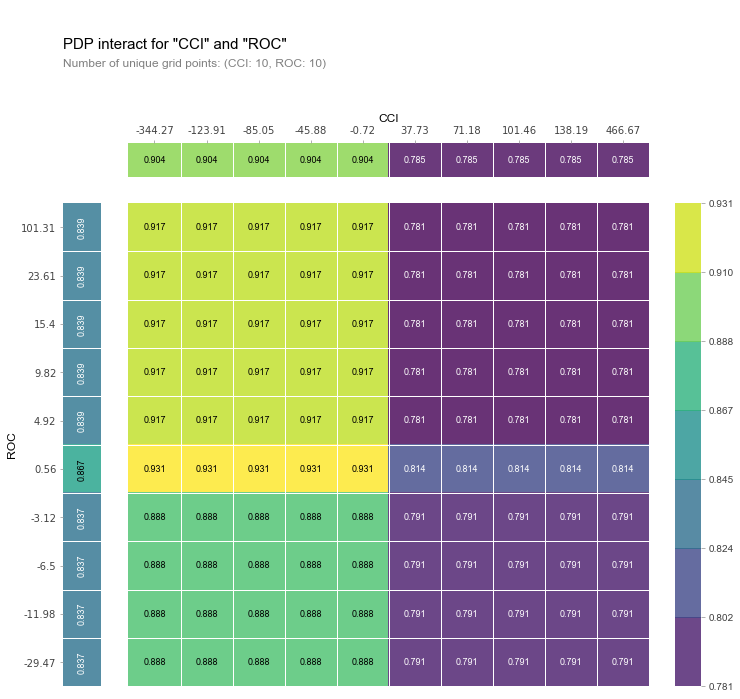

In [108]:
two_plot_interaction(df1,X.columns.tolist(),['CCI','ROC'],'grid')

# 피처 중요도 vs 부분 의존성 플롯(pdp) vs SHAP
## featrue importance 
: 예측에 가장 큰 영향을 주는 변수를 퍼뮤테이션하며 찾는 기법. 퍼뮤테이션은 피처를 돌아가며 임의로 그 값을 바꾸고, 그 변화가 예측에 주는 영향력을 계측한다. 
* 모델의 관점에 대한 설명
* 피처 영향력을 측정하는데 강력한 방법이지만, 퍼뮤테이션 정도와 에러에 기반한 추정 한계 때무네 알고리즘 실행 시마다 중요도가 다를 수 있다. 
* 또한, 피처간 의존성을 간과하는 방법이므로 피처 간 상관관계가 존재하는 모델은 피처 중요도 사용을 지양해야 한다. 피처들 몇 개가 서로 의존적이라면 피처 영향력이 잘못 계산될 수 있음.
* 각 피처가 서로 의존적일 때 과소평가된 결과를 출력하며, 상대적으로 다른 피처가 과대평가될 수 있음.


## 부분 의존성 플롯 
: 관심 피철르 조정한 값을 모델에 투입해 예측값을 구하고 평균을 낸다. 특정 피처가 변할 때 집값에 어떤 영향을 미치는지 시각화할 수 있음.
* 모델의 관점에 대한 설명
* 부분 의존성 플롯의 경우, 3차원까지의 관계만 표시할 수 있다는 한계를 가짐. 예를들어 피처 세 개가 변할 때 예측값이 어떻게 변할지 알고 싶다면 네 번째 피처가 예측에 큰 영향을 미친다면 부분 의존성 플롯은 4차원을 표현할 수 없으므로 결과가 왜곡될 수 있음. 
* 비교하고자 하는 피처가 많아진다면 시각화할 수 없고, 피처 영향력이 과대 평가될 위험이 있음.

## SHAP
: 피처 간 의존성까지 고려해서 모델의 영향력을 계산한다. (SHAP가 계산한 모든 피처의 영향력 합은 1(100%)이다.)
* 매회 계산할 때 같은 결과를 출력.
* 피처중요도가 고려하지 못하는 음의 영향력을 고려.
* 부분 의존성과 달리 하나 이상의 중요한 피처를 시각화 할 수 있음.
* 데이터 하나에 대한 설명을 구한다는 차이가 있음
* 계산시간이 오래걸림. 피처의 결측을 시뮬레이션 해야하기 때문에 계산량이 오래걸린다. 섀플리 값을 계산하기 위해 모든 피처를 순서대로 계산해야함. 따라서 
데이터 수의 제곱에 비례해 계산량이 증가함.
* 계산량이 줄면 오차의 분산이 커짐. 학습된 모델에 대해서만 설명할 수 있음. 
* 피처의 추가와 삭제가 빠른 모델을 설명하기에 적합하지 않음. 
* 아웃라이어의 등장에 허술한 해석을 내놓을 가능성이 높음. 기존 데이터를 확고하게 믿고 해석하기 때문에 아웃라이어에 데이터가 취약함.

# SHAP(SHapley Additive exPlanations)
SHAP는 섀플리 값과 피처 간 독립성을 핵심 아이더어로 사용하는 XAI기법이다. 피처 간 독립성을 근거로 덧셈이 가능하게 활용도를 넓힌 논문이다.

* 섀플리 값(Shapley value) : 전체 성과를 창출하는 데 각 참여자가 얼마나 공헌했는지를 수치로 표현하는 것. 각 사람의 기여도는 그 사람의 기여도를 제외했을 때 전체 성과의 변화 정도로 나타낼 수 있음.
* i번째 피처가 기여하는 정도는 전체 기여도에서 i번째 피처가 제외된 기여도의 합을 뺀 값이다. 
* SHAP은 모델의 출력을 각 피처의 기여도로 분해한다.

SHAP의 설명체를 정의하고 섀플리 값을 계산하는 로직

In [110]:
import shap

* **shap.initjs()**
        :SHAP 결과값을 보여주기 위해 자바스크립트 비주얼라이제이션 라이브러리를 사용한다. shap.initjs()는 주피터 노트북에 자바스크립트 프리셋을 로드한다.
* **shap.TreeExplainer**
        :설명체(explainer)는 트리 모델을 사용한다. shap.TreeExplainer는 새플리 값의 출력 형태를 앙상블 트리 형태로 시각화한다. 설명체의 종류는 모델에 따라 다르게 선언할 수 있다.
* **explainer.shap_values()**
        :설명체를 선언하면 explainer.shap_values()라는 명렁으로 섀플리 값을 계산한다. 이때 섀플리 값은 모든 학습용 데이터(X_train)에 대한 피처별 결과를 저장한다.
* **force_plot()**
        : 특정 데이터(궁금한 날짜)에 대한 섀플리 값을 상세하게 분해하고 시각화 한다. force_plot()을 실행하면 특정 데이터 하나에 대한 섀플리 값을 1차원 평면에 정렬해서 보여준다.

In [121]:
# JS 시각화 라이브러리 로드하기
shap.initjs()

# SHAP 값으로 모델의 예측을 설명하기
# 설명체는 LightGBM, CATBoost, scikit-learn 모델을 입력받을 수 있다.

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


## 하나의 데이터에 대한 섀플리 값 시각화

In [122]:

# 첫 번째 데이터에 대한 구체적 SHAP 값 시각화
shap.force_plot(explainer.expected_value,
                shap_values[0,:],
               X_train.iloc[0,:])

첫 번째 데이터는 하락으로 예측되었다.이때 주가 예측에 긍정적인 영향을 준 요소는 SOX와 MA20, ??(잘려서 안보임)이다.반면 주가 상승으로 예측되지 않게 부정적인 영향을 준 부분은 MA60, Close, S&P500, ub,VIX등이 있다.

In [120]:
# 첫 번째 데이터에 대한 구체적 SHAP 값 시각화
shap.force_plot(explainer.expected_value,
                shap_values[1700,:],
               X_train.iloc[1700,:])

1700번째 데이터는 wpr, lb, ROC가 부정적인 영향을 주었지만, KOSPI,Ma60,MA20,MACD등으로 주가 상승으로 예측되었다.

## 전체 데이터에 대한 섀플리 값 시각화

In [123]:
# 모델이 학습 데이터를 예측한 결과에 대해 SHAP 분석한 결과를 출력
shap.force_plot(explainer.expected_value, shap_values, X_train)

마우스를 올리면 n번 째 값에 영향을 받은 긍정적인 요소, 부정적인 요소를 파악할 수 있다. 복합적인 데이터가 아니라 피처 하나에 대한 전체 누적 섀플리 영향도가 궁금하다면 x축 가장 상단에 있는 드롭다운 메뉴를 열어서 특정 피처를 필터링하고 결과를 검토할 수 있다.

## 특정 피처가 타겟에 미치는 섀플리 영향도를 시각화

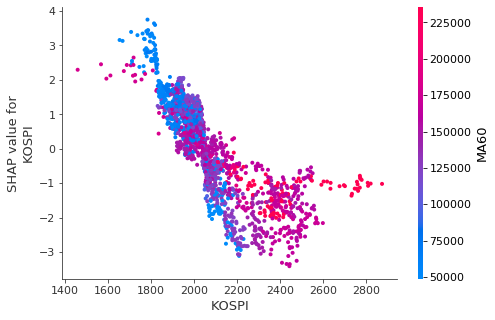

In [124]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('KOSPI', shap_values, X_train)

코스피 지수가 변함에 따라 달라지는 새플리 값을 출력한 결과이다. X축은 코스피 지수이고, Y축은 섀플리 값이다. 붉은 색 데이터는 다른 피처들보다 코스피에 주가 상승 예측에 영향력이 큰 경우를 의미하고, 파란색 데이터는 코스피가 다른 피처들에 비해 적은 영향을 미치는 경우이다.

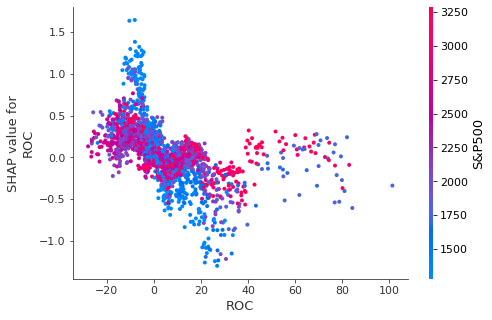

In [125]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('ROC', shap_values, X_train)

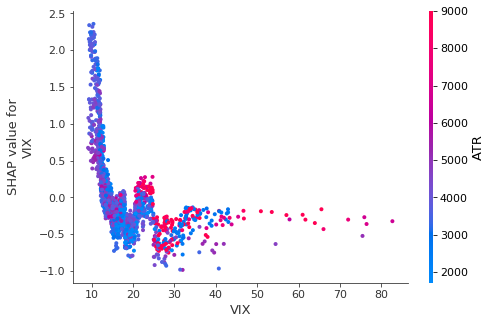

In [126]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('VIX', shap_values, X_train)

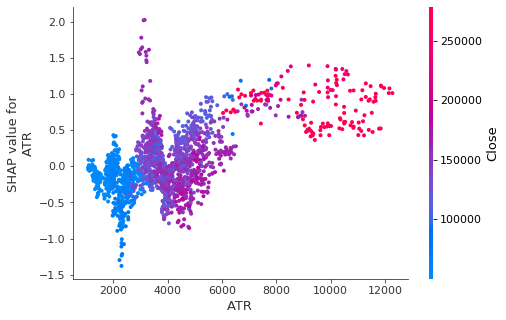

In [127]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('ATR', shap_values, X_train)

 ATR은 커질 수록 긍정적인 영향을 미치는 것을 알 수 있다. ATR과 주가 상승이 느슨한 선형 관계를 갖는 다는 것을 보여준다.

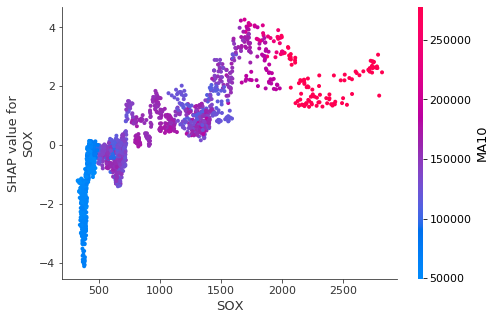

In [136]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('SOX', shap_values, X_train)

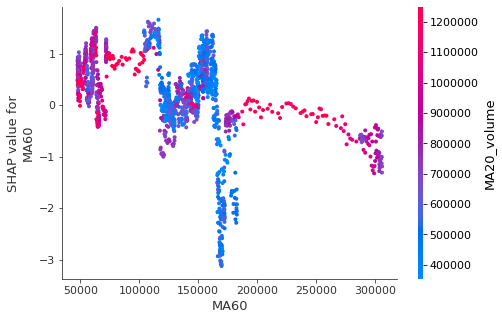

In [137]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('MA60', shap_values, X_train)

## 전체 피처들이 섀플리 값 결정에 어떻게 관여하는지 시각화

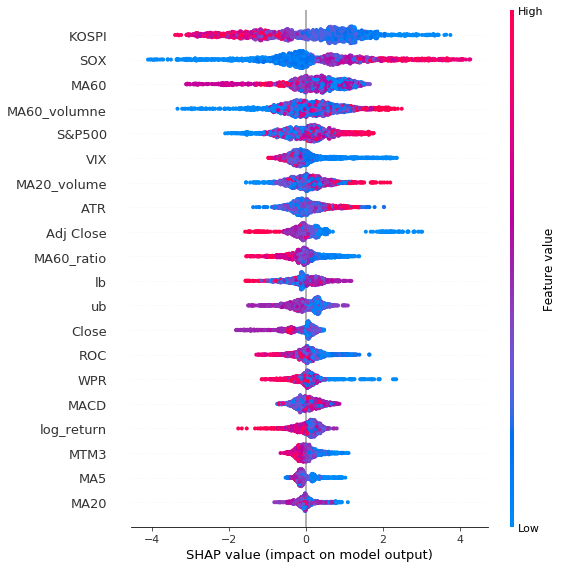

In [128]:
# 모든 피처에 대해 SHAP 값을 계산하고, 영향력을 시각화하는 코드
shap.summary_plot(shap_values, X_train)

붉은 색 점은 그 지점에 해당하는 행 피처가 주가 상승을 예측하는데 큰 영향을 미쳤음을 의미한다. 파란색 점은 행 피처가 집값을 결정하는데 적은 영향을 미쳤다는
것을 의미한다.그림에서 보는 것 처럼 KOSPI, SOX, MA60 ,MA60_volumne는 분산이 크고, 붉은 점도 위 네개에 집중되어있다. 즉, KOSPI, SOX, MA60, MA60_volumne이 주가 상승을 예측하는데 큰 역할을 한다.

색깔은 피처의 값이 작아지거나 커질 때의 상황을 표시한 것으로, 코스피는 커질 수록 붉은 색을 띠며, 적을수록 파란 색을 띤다. 즉 10년간 코스피 지수의 값이 클수록 주가가 하락했으며, 코스피 값이 작을때 주가가 상승했다. 반면 SOX는 값이 클수록 주가가 상승했으며, 값이 작을 수록 주가가 하락했다. 또한 MA60,volumne은 클수록 상승했으며, S&P500은 클수록 네이터 주가 상승에 긍정적인 영향을 미쳤다. 반면, VIX는 클수록 네이버 주가 상승에 부정적인 영향을 미쳤다,

## 피처별 섀플리 값을 막대 타입으로 비교하는 코드
summary_plot 메서드의 파라미터로 plot_type='bar'를 입력하면 각 피처가 모델에 미치는 절대 영향도를 막대그래프로 시각화 할 수 있다.

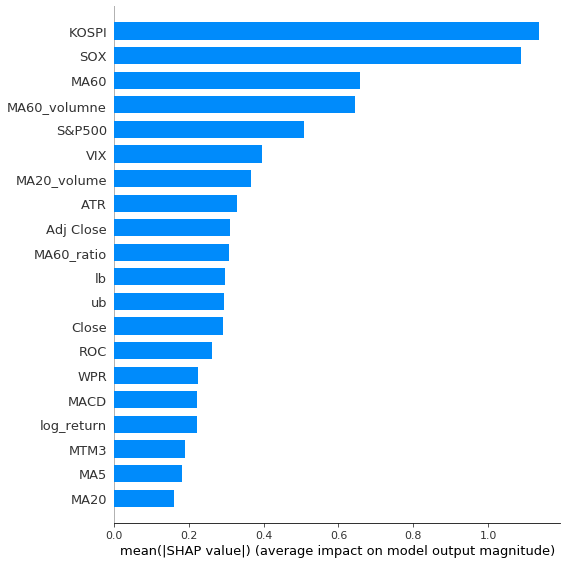

In [129]:
shap.summary_plot(shap_values,X_train, plot_type='bar')

30일 후 주가 상승을 예측하는데 가장 큰 요소는 KOSPI이며 그 다음은 SOX,MA60,MA60_volumne,S&P500 등이다.

## SHAP vs feature importance

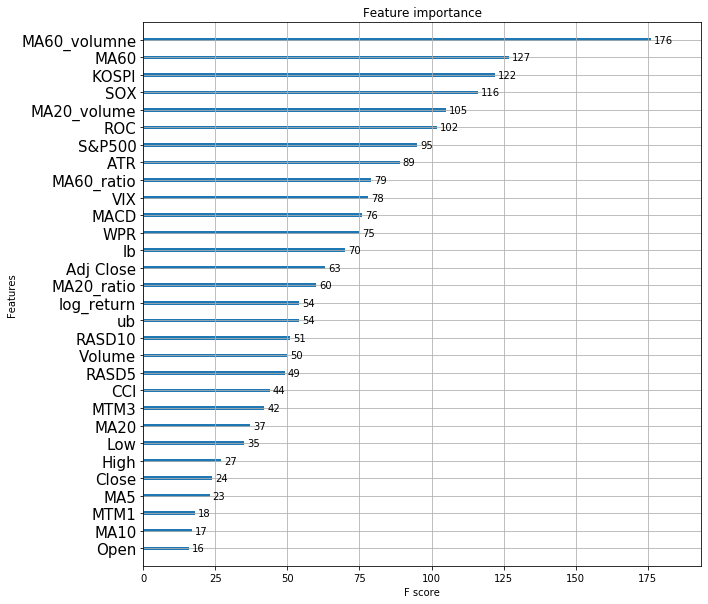

In [131]:
X = df[all_x_feature]

rcParams['figure.figsize'] = 10,10

model.get_booster().feature_names = list(X.columns)
plot_importance(model)

plt.yticks(fontsize = 15)
plt.show()

SHAP는 KOSPI, SOX, MA60 ,MA60_volumne,S&P500,VIX,AM20_volumne,ATR순으로 주가 예측에 영향을 미쳤다고 말한다. 반면, 피처중요도는 MA60_volumne,MA60,KOSPI, SOX, MA20_volume,ROC,S&P500,ATR 등 순으로 중요도를 산정했다.

_왜 피처 중요도와 SHAP는 다른 결과를 냈을까?_

피처 중요도는 퍼뮤테이션 기법을 사용해서 피처가 모델에 미치는 영향을 측정한다. 이 방법은 데이터가 약간만 조작되면 되기 때문에 계산속도가 빠르다. 그렇지만 피처들이 서로 의존적일 때는 결과가 왜곡될 수 있다. 또한, 피처 중요도는 음의 영향력은 계산하지 않는다. 이것은 피처 중요도를 계산하는 알고리즘의 특징이다. 피처중요도는 '에러가 높아지는 변인'은 결과에 포함하지 않는다. 모델이 학습할 때 음의 피처에 대해 학습을 의도적으로 무시하기 때문이다. 

**_따라서 어떤 피처가 주가 상승 예측에 부정적인 영향을 미쳐도 피처 중요도에는 반영되지 않는다.피처 중요도 기법은 실제 영향력보다 특정 피처의 가치가 높게 측정될 수 있다._**

피처 중요도는 측정이 쉽고 알고리즘이 단순해서 모델의 간편한 이해를 위해 사용된다.

반면, 섀플리 값은 피처들이 서로 영향을 미칠 가능성을 고려한다. 섀플리 값은 기본 계산량이 많아서 측정 속도가 느리다. 그렇다고 기본 계산량을 줄이면 오차의 분산이 커져 신뢰도가 떨어진다.
그렇지만 섀플리 값은 피처 간의 의존성을 고려하고 음의 영향력을 계산할 수 있다. 따라서 섀플리 값은 피처 중요도가 보장하지 못하는 넓은 범위의 함정을 피할 수 있다.

주가 예측은 피처별 의존성이 어느정도 존재한다. 예를들어, 60일간의 거래량 이동 평균이 높다면 60일간의 이동평균도 높아질 수있고, 이에 따라 종가가 상승하거나 n일의 이동평균도 상승할 수 있다. 즉, 주가 예측을 계산하는 피처는 독립적이라기 보다는 어느 정도 영향을 주고 받는다. SHAP는 전체 날짜의 주가 trend간의 상대적 피처 중요도를 표시한다. 반면, 피처 중요도는 하나의 피처에 대해 중요도를 계산할때 다른 조건들은 그대로 두고 오직 하나의 피처만 그대로 둔다. 그러나 일반적으로 금융 데이터는 비례하는 경우가 많으므로, 피처중요도는 정확하게 계산되지 않을 수 있다. 즉, 피처 중요도는 각 피처가 서로 독립적일 때 이상적으로 작동한다.

피처 중요도 계산 방식은 부정적인 영향을 주는 피처를 포함하지 않아 에러를 상승시키는 피처는 다른 피처들 보다 중요하다고 측정될 수 있음.ROC는 피처 중요도에선 
6위로 중요도가 측정되었지만 SHAP에선 중요도가 높게 측정되지않아 시각화되지않음.
이로써 ROC는 주가 상승 예측에 부정적인 영향을 주었지만,그 중요성이 과장되었음을 추측해 볼 수 있다.